# Object recognition with opencv

<img src="https://media.giphy.com/media/26tPkdXUVIRqaWWu4/giphy.gif" align="right" width="250"/>

Welcome, welcome, to **accessible computer vision** with [OpenCV](https://docs.opencv.org/4.5.1/)! **OpenCV** is short for **'open computer vision'**, so you can imagine what this **library** is all about!

OpenCV is a collection of computer vision methods, including methods described in the [README](../README.md) file of this chapter. The focus of this chapter is **object recognition**; the act of **classifying images**. This is a **supervised learning method**.

OpenCV makes it easy for us to quickly get something up and running, without too much hassle. There are many **available CNN network architectures available**, some of which are **already fully trained**. They're out-of-the-box image classifiers! So before we delve deeper into how they work, it may be useful for you to be able to use OpenCV's available tools.


## 1. Detecting regions of interest

Alright, for many object recognition tasks, you would commonly want to define **regions of interest**, also known as **ROI**. This is an important step of object recognition, since you would like to provide the actual CNN an image with **only the object of interest**, instead of an image containing many objects. An image like that would confuse the CNN and result in poor performance.

There's multiple ways to go about this, OpenCV even has its own object detection classifier based on [Haar feature-based cascade classifiers](https://docs.opencv.org/master/db/d28/tutorial_cascade_classifier.html), but it is highly dependent on what you want to detect.

Even though the built-in method of OpenCV works well, there's a handy feature of OpenCV that will come in handy for years to come; **importing existing award-winning NN models**. For this exercise, we'll want to **detect faces**, since we want to recognize something about this face. So, we'll import the **[ResNet](https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4)** model architecture **trained to detect the presence of a face in a particular area of an image**. No need to concern yourself too much with what's going on under the hood just yet, we'll take a look at that later.

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from typing import Tuple

# Load our serialized face detector model from disk
layer_info_path = "../models/deploy_res_net.prototxt"
weight_info_path = "../models/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv.dnn.readNet(layer_info_path, weight_info_path)

"**Prototxt**? **Caffemodel**? What the hell are these alien sounding extensions?"

Cool your jets, hotshot. These are simply some **[widely used NN model formats](https://caffe.berkeleyvision.org/)**. The `.prototxt` file contains info on the model structure; the number of layers, nodes, activation functions,... while the `.caffemodel` file contains the weights to all of the trainable parameters of the model!

In [2]:
image = cv.imread("../assets/guyfieri.jpg")
(height, width) = image.shape[:2]

# Construct input blob for the NN

def getBlobFromImage(image, scale_factor, output_size, mean_substraction) -> np.ndarray:
    """Get blob of size `output_size` from the `image` at a given `scale_factor`,
    and substract the `mean_substraction` from every pixel of the image."""
    return cv.dnn.blobFromImage(image, scale_factor, output_size, mean_substraction)

def getGeneralBlob(image) -> np.ndarray:
    """Get a blob from the whole image"""
    scale_factor = 1.0
    output_size = (300, 300)
    general_mean_subtraction = (104.0, 177.0, 123.0)
    return getBlobFromImage(image, scale_factor, output_size, general_mean_subtraction)


blob = getGeneralBlob(image)
blob.shape

(1, 3, 300, 300)

In [3]:
print(type(blob))

<class 'numpy.ndarray'>



You can probably guess what the scale factor and output size do, but that **mean subtraction** and **blob** may raise some eyebrows. In short, mean subtraction is an image preprocessing technique often used to **combat illumination differences** between images and **increase contrast**. 

Informally, a **blob** is just a (potentially collection) of image(s) with the same spatial dimensions (i.e., width and height), same depth (number of channels), that have all be preprocessed in the same manner.

So here, we have a collection of 1 image, with 3 channels (BGR) and of shape 300x300, like requested.

More on that right [here](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/). 

Don't lose yourself in that article though, the important thing to know is that we know have a processed **uniform blob** that our model accepts without any hassle.

In [4]:
def getDetections(blob) -> np.ndarray:
    """Pass the `blob` forward through the face detection model, and return
    the detected faces, with confidence values and coordinates"""

    face_net.setInput(blob)
    detections = face_net.forward()
    return detections.squeeze() # We remove single dimensions (1,1,200,7) --> (200,7)

detections = getDetections(blob)
detections.shape

(200, 7)

Alright, that was pretty easy, wasn't it? Now we have a set (200 to be exact) of **detection blobs** with associated **confidence values** (column 2) for each of the defined areas of the model. Our resnet model has **many output nodes**, each of which corresponds to a different image area, with additional nodes that correspond to **width** and **height** (columns 3 to 7) of the detected face.

So, the key take-away here is that the **output blob dimensions** are dependant on the **model architecture**. This is pretty important information if you want to properly index these outputs for further processing, like we do down below. The resnet model has a pretty complex output structure, no need to concern yourselves too much with this, since they're properly indexed here!

We'll create some helper methods to properly section our code so that it is easier to understand and to reduce code duplication

In [5]:
# Minimum confidence needed to detect face
minimum_confidence = 0.8

In [6]:
class BoundingBox:
    """Create a colored bounding box to draw over the image."""
    def __init__(self, start_x, start_y, end_x, end_y):
        self.start_x = start_x
        self.start_y = start_y
        self.end_x = end_x
        self.end_y = end_y
        
        self.color = (0,0,255) # RED (BGR)
        self.thickness = 2

    def drawOn(self, image) -> None:
        """Draw a rectangular bounding box on the `image` using `cv.rectangle`
        
        Side effect: the `image` object is modified.
        
        Parameters
        ----------
        image : np.ndarray
            Image to draw the bounding box on.
        """
        cv.rectangle(
            image, 
            (self.start_x, self.start_y), 
            (self.end_x, self.end_y), 
            self.color, 
            self.thickness
        )

def get_bounding_box(detection, width, height) -> BoundingBox:
    """ Computes the (x, y)-coordinates of the bounding box.
    
    Parameters
    ----------
        detection : np.ndarray
            Detected image of a face.
        width : int
            Height of the whole image.
        height : int
            Height of the whole image.

    Returns
    ----------
        BoundingBox
            Bounding box surrounding the face.
    """
    
    # Coordinates as a fraction of the total width/height
    coordinate_fractions = detection[3:7]
    box = coordinate_fractions * np.array([width, height, width, height])
    (start_x, start_y, end_x, end_y) = box.astype("int")
    return BoundingBox(start_x, start_y, end_x, end_y)


def plot_image(image) -> None:
    """Plot the image.

    Parameters
    ----------
        image : np.ndarray
            Image to plot.
    """
    # Convert image from bgr to rgb format
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Display the output image
    plt.figure(figsize=(16,16))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title('flavortown')
    plt.show()

Now, we do the actual face detection using our defined methods.

Here, we loop through all of the potential detected faces, only selecting
those that the algorithm is most confident about and drawing a bounding box around it.


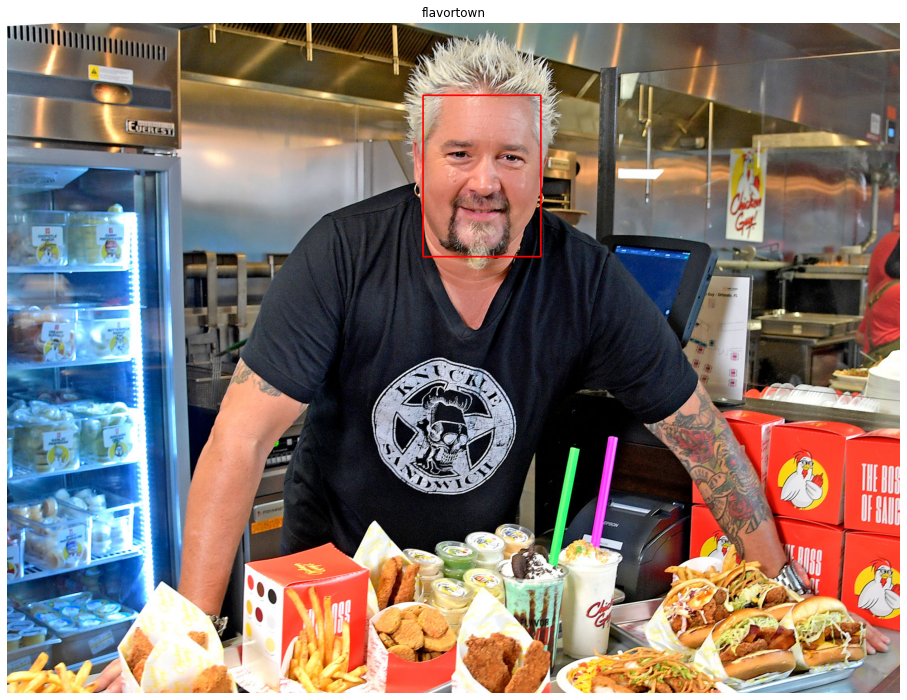

In [7]:
for detection in detections:
    # Extract the confidence (i.e., probability) associated with the prediction
    confidence = detection[2]
    
    if confidence > minimum_confidence:
        bounding_box = get_bounding_box(detection, width, height)
        bounding_box.drawOn(image)

plot_image(image)

Alright! We're feeling the heat, but we're not all the way in Flavortown just yet! We've detected a **ROI**; Guy Fieri's face, but we can do further analysis on him, now that we **isolated** his most defining feature (apart from his timeless frosted tips).

## 2. Classifying regions of interest

Let's see **how old** Guy Fieri was at the time of this iconic picture. Or at least, [this](https://talhassner.github.io/home/publication/2015_CVPR) model's estimation of Fieri's age. **Age** is a pretty subjective metric to evaluate, so the results may be a bit off, though we can **relax** the problem a bit by letting the classifier classify people in different **time-ranges** (e.g. 25-30).

For this, we need to load said model just like before:

In [8]:
# Load our serialized age classifier model from disk
layer_info_path = "../models/deploy_age_net.prototxt"
weight_info_path = "../models/age_net.caffemodel"
age_net = cv.dnn.readNet(layer_info_path, weight_info_path)

Then, let's define the **age buckets** (these are dictated by the model paper).

In [9]:
# Define the list of age buckets our age detector will predict
age_buckets = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

Now, we'll add some lines of code to also detect age right after defining the ROI. 

In [10]:
def get_face_blob(image) -> np.ndarray:
    """ Create blobs from an`image` of a face with the aim of 
    predicting an age.

    Parameters
    ----------
    image : np.ndarray
        Image of a face.

    Returns
    ----------
    np.ndarray
        Blob of the face.
    """
    scale_factor = 1.0
    # Mean subtraction values for faces (predetermined)
    face_mean_subtraction = (78.0, 87.0, 115.0)
    # Output size of the cropped face
    face_output_size = (227, 227)
    return getBlobFromImage(image, scale_factor, face_output_size, face_mean_subtraction)

def extract_face_ROI(image, bounding_box : BoundingBox) -> np.ndarray:
    """ Extract the region of interest (ROI) (the face) from the image and construct a
    blob from it.

    Parameters
    ----------
    image : np.ndarray
        Image from which to extract a face.

    bounding_box : BoundingBox
        Bounding box delimiting a face.

    Returns
    ----------
    np.ndarray
        Blob of the face.
    """
    face = image[bounding_box.start_y:bounding_box.end_y, 
                 bounding_box.start_x:bounding_box.end_x]
    return get_face_blob(face)


def predict_age(age_net, face_blob, age_buckets) -> Tuple[str, float]:
    """Make predictions on the age from the `face_blob` using `age_net`
    and find the age bucket with the largest corresponding confidence.

    Parameters
    ----------
    age_net : cv.dnn
        Neural network to predict the age.

    face_blob : np.ndarray
        Blob of the face.

    age_buckets : list[str]
        List of age ranges

    Returns
    ----------
    age : str
        Predicted age range from `age_buckets`
    age_confidence : float
        Confidence in the predicted age
    """
    age_net.setInput(face_blob)
    predictions = age_net.forward()
    max_conf_index = predictions[0].argmax()
    age = age_buckets[max_conf_index]
    age_confidence = predictions[0][max_conf_index]
    
    return age, age_confidence

def draw_age_range(image, age, age_confidence, bounding_box : BoundingBox) -> None:
    """Make predictions on the age from the `face_blob` using `age_net`
    and find the age bucket with the largest corresponding confidence.

    Parameters
    ----------
    image : np.ndarray
        Image to draw the age range on.
    age : str
        Predicted age range.
    age_confidence : float
        Confidence in the predicted age range.
    bounding_box : BoundingBox
        Bounding box delimiting a face.
    """
    # Draw the age range above the bounding box

    start_y = bounding_box.start_y
    y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    text = "{}: {:.2f}%".format(age, age_confidence * 100)
    cv.putText(image, 
               text,
               (bounding_box.start_x, y), 
               cv.FONT_HERSHEY_SIMPLEX, 
               1, 
               (0, 0, 255), # RED 
               2) #Line thickness
        

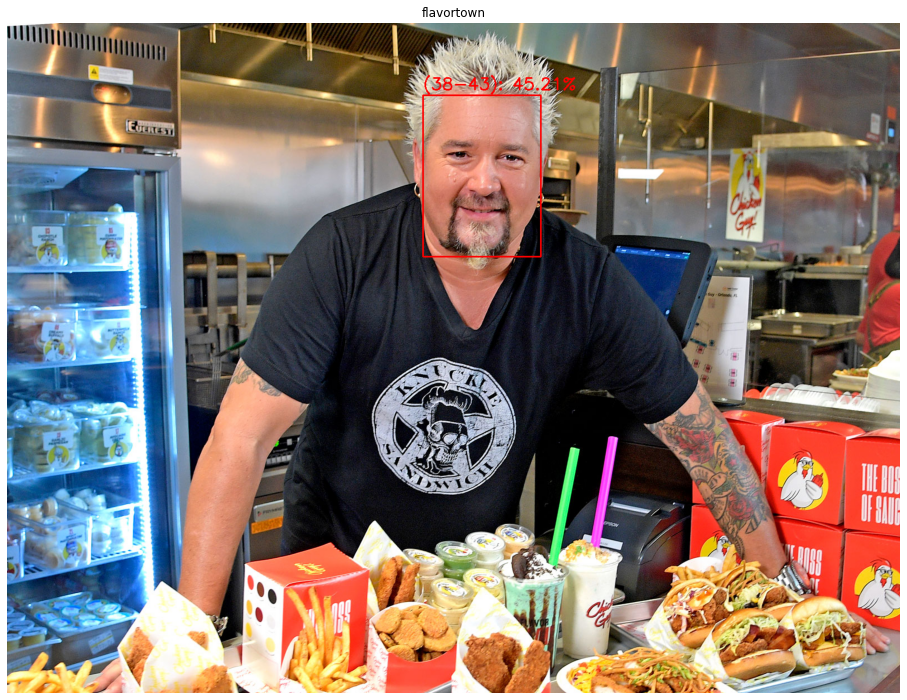

In [11]:
# loop over the detections
for detection in detections:
    # Extract the confidence (i.e., probability) associated with the prediction
    confidence = detection[2]
    
    # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > minimum_confidence:
        bounding_box = get_bounding_box(detection, width, height)
        bounding_box.drawOn(image)

        face_blob = extract_face_ROI(image, bounding_box)
        
        age, age_confidence = predict_age(age_net, face_blob, age_buckets)
        draw_age_range(image, age, age_confidence, bounding_box)


plot_image(image)

Alright, we've got a result! **38-43** is the classifiers guess. That's close, but no cigar, considering Guy's age at the time of this picture was **just over 50**. Maybe those frosted tips keep him looking eternally youthful.

Or there may be other factors at play here. Notice how the **confidence** is also very low, meaning the classifier is having trouble tracking defining age indicators on Fieri's face. **discuss this** with colleagues, what could possible reasons for the model's poor performance with Fieri pics?

## 3. Interactive demo

Lastly, let's see how old **you** all are!

In [12]:
def classify_age(frame, face_net, min_conf=0.5):    
    # Initialize our results list
    results = []
    
    # Grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = getGeneralBlob(frame)
    
    # Pass the blob through the network and obtain the face detections
    detections = getDetections(blob)
    
    # loop over the detections
    for detection in detections:
        # Extract the confidence (i.e., probability) associated with the prediction
        confidence = detection[2]
        
        # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > min_conf:
            bounding_box = get_bounding_box(detection, w, h)
            face_blob = extract_face_ROI(frame, bounding_box)
            age, age_confidence = predict_age(age_net, face_blob, age_buckets)

            # Construct a dictionary consisting of both the face bounding box location 
            # along with the age prediction, then update our results list
            result = {
                "loc": bounding_box,
                "age": (age, age_confidence)
            }
            results.append(result)

    # Return our results to the calling function
    return results

In [13]:
'''Run this cell to start the live demo'''

from imutils.video import VideoStream
import imutils

# Initialize the video stream
vs = VideoStream(src=0).start()

# Loop over the frames from the video stream
try:
    while True:
        # Grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
        frame = vs.read()
        frame = imutils.resize(frame, width=400)

        # Detect faces in the frame, and for each face in the frame, predict the age
        results = classify_age(frame, age_net, min_conf=0.8)

        # Loop over the results
        for r in results:
            # Draw the bounding box(es) of the face(s) along with the associated predicted age
            age, age_confidence = r["age"]
            bounding_box= r["loc"]
            draw_age_range(frame, age, age_confidence, bounding_box)
            bounding_box.drawOn(frame)

        # Show the output frame
        cv.imshow("Frame", frame)
        key = cv.waitKey(1) & 0xFF
        # If the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
except:
    raise
finally:
    # Do a bit of cleanup
    cv.destroyAllWindows()
    vs.stop()
    vs.stream.release()


KeyboardInterrupt: 

## 4. Conclusion

Alright, now you've had a taste on how to quickly **implementing existing models** using **OpenCV**. If the performance of the classifier isn't to your liking, then **just import another**! That's the neat thing about pre-trained networks, you can use what's already out there.

Let's get to looking a bit **under the hood** on how CNN's work in [the next notebook](./5.object_recognition_from_scratch_with_keras.ipynb).